# Weight Transfer From Classification To Segmentation

<br>
<b>about</b> : This notebook explores the comparisons on segmentation performance (in terms of dice coefficient) between image-net weight leveraged Unet model and data-specific-classification weight leveraged Unet model.

*Code Writer: Chaeeun Ryu*

In [1]:
!nvidia-smi

Tue Feb 28 17:05:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    21W / 300W |    243MiB / 11264MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
import argparse
import os
import random
import time
import warnings
import sys
import numpy as np
import torch
import torch.nn 
import torchvision.transforms as transforms
from collections import Counter, OrderedDict
import torch.optim
from sklearn.metrics import confusion_matrix
from torchvision.datasets import OxfordIIITPet
import os
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import torchvision.models as models
import glob
import copy
from torchvision.models import resnet50, ResNet50_Weights
import torchvision
import matplotlib.pyplot as plt
device =  torch.device('cuda:0')

# Config

In [3]:
from dataclasses import dataclass
@dataclass
class ARGS():
    LR = 0.005
    EPOCHS = 200
    BATCHSIZE = 64
    MOMENTUM = 0.9
    WORKERS = 0
    WEIGHTDECAY = 0
    T_MAX = 25
    CLS_CLASS = 37
    SEG_CLASS = 3
    SIZE = 224
args = ARGS()

# Get dataset

In [4]:
transform_train = transforms.Compose([
        transforms.Resize((args.SIZE,args.SIZE)),
        transforms.RandomCrop(args.SIZE, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_val = transforms.Compose([
        transforms.Resize((args.SIZE,args.SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
_tr_transform = [
        A.Resize(height = args.SIZE, width = args.SIZE,p=1),
        A.Rotate(limit=30,p=0.3),
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
_val_transform = [
        A.Resize(height = args.SIZE, width = args.SIZE,p=1),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
to_tensor = A.Compose([ToTensorV2()])
seg_transform_train = A.Compose(_tr_transform)
seg_transform_val = A.Compose(_val_transform)

#### Datasets

In [6]:
classification_train_dataset = OxfordIIITPet(root='./data', split="trainval", target_types = 'category',download=True, transform=transform_train)
classification_val_dataset = OxfordIIITPet(root='./data', split="test", target_types = 'category',download=True, transform=transform_val)

In [7]:
_segmentation_train_dataset = OxfordIIITPet(root='./data', split="trainval", target_types = 'segmentation',download=True)
_segmentation_val_dataset = OxfordIIITPet(root='./data', split="test", target_types = 'segmentation', download=True)

In [8]:
from torch.utils.data import Dataset, DataLoader
class SegDataset(Dataset):
    def __init__(self, dataset, transform):
        self.tf = transform
        self.dataset = dataset
    
    def __len__(self):
        return self.dataset.__len__()
    
    def __getitem__(self, idx):
        img_tuple, mask_tuple = self.dataset.__getitem__(idx)
        sample = self.tf(image = np.array(img_tuple), mask= np.array(mask_tuple))
        img,mask = sample["image"],sample["mask"]
        return img,mask

In [9]:
segmentation_train_dataset = SegDataset(_segmentation_train_dataset,seg_transform_train)
segmentation_val_dataset = SegDataset(_segmentation_val_dataset,seg_transform_val)

In [10]:
len(classification_train_dataset.classes)

37

#### Dataloaders

In [11]:
global classification_loaders
classification_loaders = dict()
classification_train_loader = torch.utils.data.DataLoader(
            classification_train_dataset, batch_size=args.BATCHSIZE, shuffle=True,
            num_workers=args.WORKERS, pin_memory=True)
classification_val_loader = torch.utils.data.DataLoader(
    classification_val_dataset, batch_size=args.BATCHSIZE, shuffle=False,
    num_workers=args.WORKERS, pin_memory=True)

classification_loaders['train_loader'] = classification_train_loader
classification_loaders['val_loader'] = classification_val_loader

In [12]:
global segmentation_loaders
segmentation_loaders = dict()

segmentation_train_loader = torch.utils.data.DataLoader(
            segmentation_train_dataset, batch_size=args.BATCHSIZE, shuffle=True,
            num_workers=args.WORKERS, pin_memory=True)
segmentation_val_loader = torch.utils.data.DataLoader(
    segmentation_val_dataset, batch_size=args.BATCHSIZE, shuffle=False,
    num_workers=args.WORKERS, pin_memory=True)

segmentation_loaders['train_loader'] = segmentation_train_loader
segmentation_loaders['val_loader'] = segmentation_val_loader

In [13]:
batch_img,batch_label = next(iter(segmentation_train_loader))

In [14]:
sample_img,sample_label = classification_train_dataset.__getitem__(0)

In [15]:
sample_img,sample_label = segmentation_train_dataset.__getitem__(0)

In [16]:
sample_img.size()

torch.Size([3, 224, 224])

In [17]:
sample_label.size()

torch.Size([224, 224])

# Method 1: Indiv models

## Classification

In [13]:
'''ResNet in PyTorch.
Reference:
https://github.com/kuangliu/pytorch-cifar
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace = True) 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         print("block.expansion:",block.expansion) == 1
#         self.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512*block.expansion, num_classes)
        
#         self.linear = nn.Linear(8192, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out1 = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
#         out = F.avg_pool2d(out4, 4)
        out = self.avgpool(out4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out, [out1, out2, out3, out4]


def ResNet50(num_classes):
    return ResNet(Bottleneck, [3,4,6,3],num_classes)


indiv_classification_model = ResNet50(args.CLS_CLASS)#.load_state_dict(resnet50(pretrained=ResNet50_Weights.IMAGENET1K_V2).state_dict())

In [14]:
indiv_classification_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

## Leverage ImageNet weights

In [20]:
pretrained_model = models.resnet50(pretrained=ResNet50_Weights.IMAGENET1K_V2)

model_weight = copy.deepcopy(indiv_classification_model.state_dict())
pretrained_model_weight = copy.deepcopy(pretrained_model.state_dict())

idx = 0
for name, pretrained_weight in zip(indiv_classification_model.state_dict().keys(),pretrained_model_weight.values()):
    if idx == 318 or idx == 319:
        pass
    else:
        print(name)
        assert model_weight[name].size() == pretrained_weight.size()
        model_weight[name] = pretrained_weight
    idx+=1

indiv_classification_model.load_state_dict(model_weight)

C:\Users\KIST\anaconda3\envs\CH\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KIST\anaconda3\envs\CH\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.bn3.running_mean
layer1.0.bn3.running_var
layer1.0.bn3.num_batches_tracked
layer1.0.shortcut.0.weight
layer1.0.shortcut.1.weight
layer1.0.shortcut.1.bias
layer1.0.shortcut.1.running_mean
layer1.0.shortcut.1.running_var
layer1.0.shortcut.1.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer1

<All keys matched successfully>

### Utils

In [21]:
import random
def train(train_loader, model, criterion, optimizer, device, epoch, data_name = ""):
    losses = []#AverageMeter('Loss', ':.4e')
    top1 = []#AverageMeter('Acc@1', ':6.2f')
    model.train()
    # switch to train mode
    for i, (x, label) in enumerate(train_loader):
        # measure data loading time
        x = x.to(device)
        label = label.to(device)
        # compute output
        output,_ = model(x)
#         print(output
        
        loss = criterion(output, label)
        preds = torch.argmax(output,dim=1)
#         print("pred:",preds)
#         print("label:",label)
        # measure accuracy and record loss
        acc1 = (torch.sum((preds==label)*1)/len(preds)).item()
        losses.append(loss.item())
        top1.append(acc1)

        # compute gradient and do SGD step
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
#     print(top1)
#     print(losses)
    return np.mean(top1),np.mean(losses)

In [22]:
def eval(val_loader, model, criterion, device):
    losses = []#AverageMeter('Loss', ':.4e')
    top1 = []#AverageMeter('Acc@1', ':6.2f')
    model.eval()
    
    with torch.no_grad():
        for i, (x, label) in enumerate(val_loader):
            x = x.to(device)
            label = label.to(device)
            output,_ = model(x)
            loss = criterion(output, label)
            preds = torch.argmax(output,dim=1)
    #         print("pred:",preds)
    #         print("label:",label)
            # measure accuracy and record loss
            acc1 = (torch.sum((preds==label)*1)/len(preds)).item()
            losses.append(loss.item())
            top1.append(acc1)

    return np.mean(top1),np.mean(losses)

In [23]:
criterion = nn.CrossEntropyLoss().to(device)
best_val_top1_err = 100

indiv_classification_optimizer = torch.optim.SGD(indiv_classification_model.parameters(), args.LR,
                            momentum=args.MOMENTUM,
                            weight_decay=args.WEIGHTDECAY)

indiv_classification_scheduler = CosineAnnealingLR(indiv_classification_optimizer, T_max = args.T_MAX)

In [24]:
classification_loaders.keys()

dict_keys(['train_loader', 'val_loader'])

In [25]:
from tqdm.notebook import tqdm
import copy
indiv_classification_model.to(device)
best_val_acc = 0.
save_train_acc = []
save_val_acc = []
save_train_loss= []
save_val_loss = []

max_patience = 15
# save_epoch = copy.deepcopy(epoch)
# print("Data name:",data_name)
for epoch in tqdm(range(0, args.EPOCHS + 1)):
    #def train(train_loader, model, criterion, optimizer, device, epoch, data_name = "")
    train_acc, train_loss = train(classification_loaders['train_loader'], indiv_classification_model, criterion, indiv_classification_optimizer, device, epoch)
    val_acc,val_loss = eval(classification_loaders['val_loader'], indiv_classification_model, criterion, device)
    save_train_acc.append(train_acc)
    save_val_acc.append(val_acc)
    save_train_loss.append(train_loss)
    save_val_loss.append(val_loss)
    print(f"epoch:{epoch} train acc:{train_acc}")
    state = {
    'epoch': epoch,
    'state_dict': indiv_classification_model.state_dict(),
    'optimizer':indiv_classification_optimizer.state_dict(),
    'train_acc':train_acc,
    'val_acc':val_acc,   
    }

    if val_acc>best_val_acc:
        best_val_acc = val_acc
        best_model_path = (f'./indiv_classification_model_best_epoch{epoch}.pth')
        #print(f"epoch {epoch}: best model updated")
        print(f"[epoch: {epoch}] model updated! train acc:",train_acc, "val_acc:",val_acc)
        #torch.save(state, best_model_path)
        best_model = copy.deepcopy(indiv_classification_model)
        patience = 0
    else:
        patience +=1
    
    if patience > max_patience:
        break
    indiv_classification_scheduler.step()

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:0 train acc:0.6468211206896551
[epoch: 0] model updated! train acc: 0.6468211206896551 val_acc: 0.884351909160614
epoch:1 train acc:0.9331896551724138
[epoch: 1] model updated! train acc: 0.9331896551724138 val_acc: 0.9056983785382633
epoch:2 train acc:0.9727909482758621
epoch:3 train acc:0.9886853448275862
[epoch: 3] model updated! train acc: 0.9886853448275862 val_acc: 0.917808395007561
epoch:4 train acc:0.994073275862069
[epoch: 4] model updated! train acc: 0.994073275862069 val_acc: 0.923760775862069
epoch:5 train acc:0.9978448275862069
epoch:6 train acc:0.9967672413793104
[epoch: 6] model updated! train acc: 0.9967672413793104 val_acc: 0.9259031199175736
epoch:7 train acc:0.998114224137931
epoch:8 train acc:0.9973060344827587
epoch:9 train acc:0.9994612068965517
[epoch: 9] model updated! train acc: 0.9994612068965517 val_acc: 0.9299440681934357
epoch:10 train acc:0.9994612068965517
[epoch: 10] model updated! train acc: 0.9994612068965517 val_acc: 0.9323686371589529
epoch:11 

In [26]:
torch.save({'save_train_acc':save_train_acc,'save_val_acc':save_val_acc,'save_train_loss':save_train_loss,'save_val_loss':save_val_loss},"indiv_class.pt")

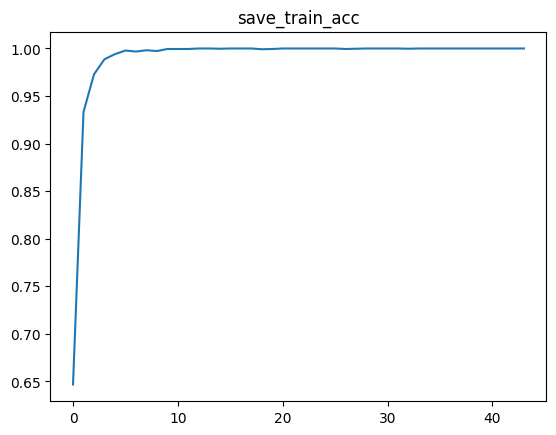

In [27]:
plt.title("save_train_acc")
plt.plot(save_train_acc)
plt.show()

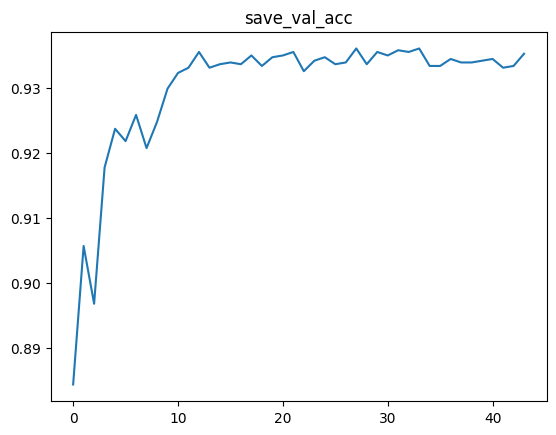

In [28]:
plt.title("save_val_acc")
plt.plot(save_val_acc)
plt.show()

In [29]:
max(save_val_acc)

0.9361401888830908

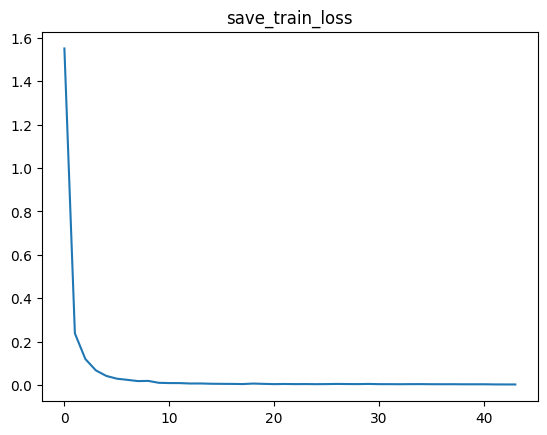

In [30]:
plt.title("save_train_loss")
plt.plot(save_train_loss)
plt.show()

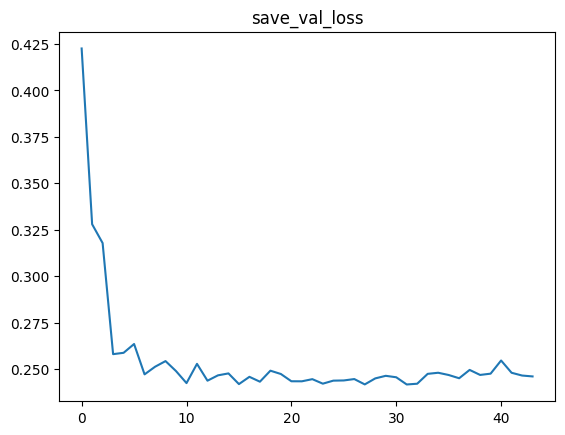

In [31]:
plt.title("save_val_loss")
plt.plot(save_val_loss)
plt.show()

## Indiv Segmentation model (Weight = ImageNet)

In [53]:
import segmentation_models_pytorch as smp

indiv_segmentation_imagenet_model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)
indiv_segmentation_imagenet_model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [54]:
from segmentation_models_pytorch.losses import FocalLoss
# from segmentation_models_pytorch.losses import |
criterion = FocalLoss(mode='multiclass')
indiv_segmentation_imagenet_optimizer = torch.optim.SGD(indiv_segmentation_imagenet_model.parameters(), args.LR,
                            momentum=args.MOMENTUM,
                            weight_decay=args.WEIGHTDECAY)

indiv_segmentation_imagenet_scheduler = CosineAnnealingLR(indiv_segmentation_imagenet_optimizer, T_max = args.T_MAX)

### Utils

In [27]:
import torch
def soft_dice_score(
    output: torch.Tensor,
    target: torch.Tensor,
    smooth: float = 0.0,
    eps: float = 1e-7,
    dims=None,
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

In [28]:
def multiclass_dice_score(pred,mask):
    #storage
    class_dice = dict()
    #calculate dice per batch
    for class_ in range(1,args.SEG_CLASS+1):
        if torch.sum((pred == class_)*1) == 0 and torch.sum((mask == class_)*1) == 0:
            pass
        else:
            pred_ = (pred==class_)*1
            label_ = (mask==class_)*1
            dice = soft_dice_score(pred_,label_)
            class_dice[class_] = dice.item()
    return class_dice

In [29]:
def train_seg(train_loader,model,criterion, optimizer, device):
    losses = []
    train_dice_dict = dict()
    model.to(device)
    model.train()
    for image, mask in train_loader:
        image,mask = image.to(device), mask.to(device)
        logits = model(image)
        preds = torch.argmax(logits, axis = 1)
#         print("logits:",logits.size())
#         print(logits)
#         print("mask:",mask.size())
#         print("preds",preds.size())
        loss = criterion(logits,mask)
        dice_dict = multiclass_dice_score(preds,mask)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        for key in dice_dict.keys():
            if key in train_dice_dict:
                train_dice_dict[key].append(dice_dict[key])
            else:
                train_dice_dict[key] = [dice_dict[key]]
    
    #average dice dict
    for key in train_dice_dict.keys():
        train_dice_dict[key] = np.mean(train_dice_dict[key])
    return np.mean(losses), train_dice_dict

In [30]:
def eval_seg(val_loader, model, criterion, device):
    losses = []
    val_dice_dict = dict()        
    model.eval()
    with torch.no_grad():
        for image, mask in val_loader:
            image,mask = image.to(device),mask.to(device)
            logits = model(image)
            preds = torch.argmax(logits, axis = 1).to(torch.float64)
            loss = criterion(logits,mask)
            dice_dict = multiclass_dice_score(preds,mask)
            losses.append(loss.item())
            for key in dice_dict.keys():
                if key in val_dice_dict:
                    val_dice_dict[key].append(dice_dict[key])
                else:
                    val_dice_dict[key] = [dice_dict[key]]
    #average dice dict
    for key in val_dice_dict.keys():
        val_dice_dict[key] = np.mean(val_dice_dict[key])
    return np.mean(losses), val_dice_dict

In [59]:
from tqdm.notebook import tqdm
save_train_loss = []
save_train_dice =[]
save_val_loss = []
save_val_dice = []
best_val_dice = 0.
best_val_acc = 0.
max_patience = 15
indiv_segmentation_imagenet_model.to(device)

for epoch in tqdm(range(args.EPOCHS)):
    train_loss, train_dice = train_seg(segmentation_loaders['train_loader'], indiv_segmentation_imagenet_model, criterion, indiv_segmentation_imagenet_optimizer,device)
    val_loss, val_dice = eval_seg(segmentation_loaders['val_loader'], indiv_segmentation_imagenet_model, criterion, device)
    avg_train_dice, avg_val_dice = np.mean(list(train_dice.values())),np.mean(list(val_dice.values()))
    save_train_dice.append(avg_train_dice)
    save_val_dice.append(avg_val_dice)
    save_train_loss.append(train_loss)
    save_val_loss.append(val_loss)
    print(f"======= epoch {epoch} ========")
    print("train loss:",train_loss, "val_loss:",val_loss)
    print("avg train dice:",avg_train_dice,"avg val dice:",avg_val_dice)
    print("train dice:",train_dice)
    print("val dice:",val_dice)
    if avg_val_dice > best_val_dice:
        print("model updated at epoch:",epoch)
        best_model = copy.deepcopy(indiv_segmentation_imagenet_model)
        best_val_dice = avg_val_dice
        patience = 0
    else:
        patience +=1
    
    if patience > max_patience:
        break
    indiv_segmentation_imagenet_scheduler.step()
torch.save({"save_train_loss":save_train_loss,"save_train_dice":save_train_dice,"save_val_loss":save_val_loss,"save_val_dice":save_val_dice},"seg_log.pt")

  0%|          | 0/200 [00:00<?, ?it/s]

======= epoch 0 ========
train loss: 0.3963169142090041 val_loss: 0.24704337633889298
avg train dice: 0.49732388241280767 avg val dice: 0.575722473405901
train dice: {1: 0.6318977819434528, 2: 0.8075653756486958, 3: 0.05250848964627447}
val dice: {1: 0.785026231716419, 2: 0.8694748642115757, 3: 0.0726663242897083}
model updated at epoch: 0
======= epoch 1 ========
train loss: 0.21030365136162987 val_loss: 0.1830921083174903
avg train dice: 0.6473070491833248 avg val dice: 0.7055536679837896
train dice: {1: 0.8281861163418869, 2: 0.9051816720387031, 3: 0.20855335916938453}
val dice: {1: 0.8537446743455427, 2: 0.9249089154703863, 3: 0.33800741413543967}
model updated at epoch: 1
======= epoch 2 ========
train loss: 0.17625160078550206 val_loss: 0.16317025546369882
avg train dice: 0.7193225027843454 avg val dice: 0.7570396189031929
train dice: {1: 0.857253774486739, 2: 0.9260612459018313, 3: 0.3746524879644657}
val dice: {1: 0.8724668693953547, 2: 0.9351429857056717, 3: 0.4635090016085526

In [73]:
torch.save({"best_model_w":indiv_classification_model.state_dict()},"best_classification_model.pt")

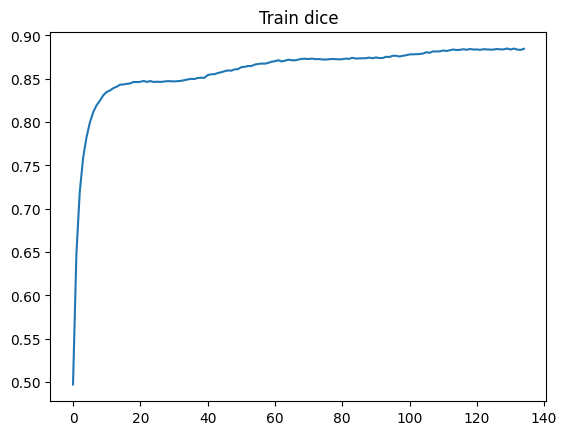

In [61]:
plt.title("Train dice")
plt.plot(save_train_dice)
plt.show()

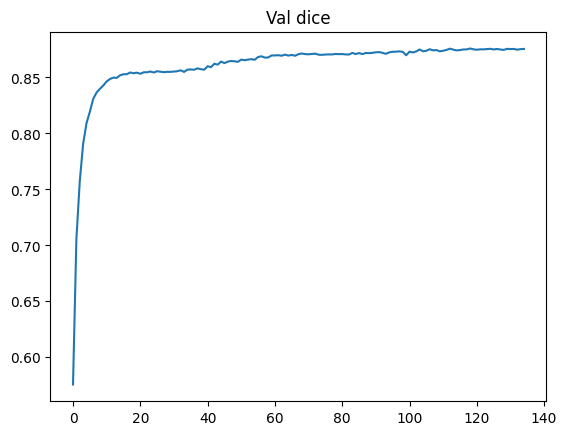

In [62]:
plt.title("Val dice")
plt.plot(save_val_dice)
plt.show()

In [63]:
max(save_val_dice)

0.8759183489728248

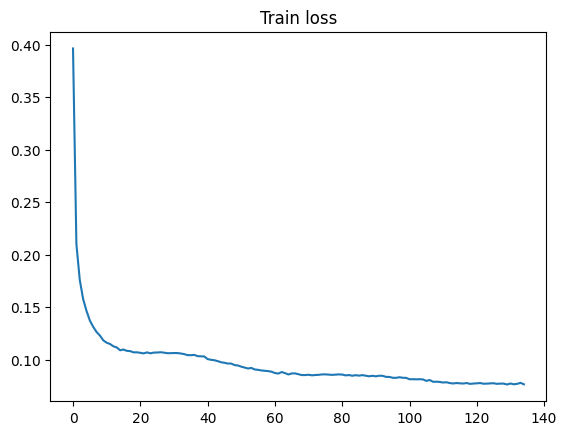

In [64]:
plt.title("Train loss")
plt.plot(save_train_loss)
plt.show()

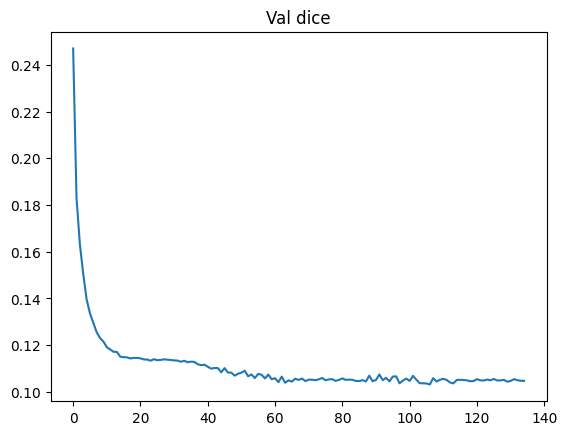

In [65]:
plt.title("Val dice")
plt.plot(save_val_loss)
plt.show()

## Indiv Segmentation model (Weight = Classification model)

In [17]:
indiv_classification_model.load_state_dict(torch.load("./best_classification_model.pt")["best_model_w"])

<All keys matched successfully>

In [18]:
indiv_classification_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [20]:
import segmentation_models_pytorch as smp

indiv_segmentation_from_cls_model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=args.SEG_CLASS+1,                      # model output channels (number of classes in your dataset)
)
indiv_segmentation_from_cls_model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

#### Leverage classification model w

In [21]:
seg_w = copy.deepcopy(indiv_segmentation_from_cls_model.encoder.state_dict())
class_w = copy.deepcopy(indiv_classification_model.state_dict())

In [22]:
idx = 0
for name, pretrained_weight in zip(seg_w.keys(),class_w.values()):
    assert seg_w[name].size() == pretrained_weight.size()
    seg_w[name] = pretrained_weight
    idx+=1

In [23]:
for seg_w_,class_w_ in zip(seg_w.values(),class_w.values()):
    assert seg_w_.size() == class_w_.size()
    assert torch.equal(seg_w_,class_w_) == True

load

In [24]:
indiv_segmentation_from_cls_model.encoder.load_state_dict(seg_w)

#### Settings

In [25]:
from segmentation_models_pytorch.losses import FocalLoss
# from segmentation_models_pytorch.losses import |
criterion = FocalLoss(mode='multiclass')
indiv_segmentation_from_cls_optimizer = torch.optim.SGD(indiv_segmentation_from_cls_model.parameters(), args.LR,
                            momentum=args.MOMENTUM,
                            weight_decay=args.WEIGHTDECAY)

indiv_segmentation_from_cls_scheduler = CosineAnnealingLR(indiv_segmentation_from_cls_optimizer, T_max = args.T_MAX)

In [31]:
from tqdm.notebook import tqdm
save_train_loss = []
save_train_dice =[]
save_val_loss = []
save_val_dice = []
best_val_dice = 0.
best_val_acc = 0.
max_patience = 15
indiv_segmentation_from_cls_model.to(device)

for epoch in tqdm(range(args.EPOCHS)):
    train_loss, train_dice = train_seg(segmentation_loaders['train_loader'], indiv_segmentation_from_cls_model, criterion, indiv_segmentation_from_cls_optimizer,device)
    val_loss, val_dice = eval_seg(segmentation_loaders['val_loader'], indiv_segmentation_from_cls_model, criterion, device)
    avg_train_dice, avg_val_dice = np.mean(list(train_dice.values())),np.mean(list(val_dice.values()))
    save_train_dice.append(avg_train_dice)
    save_val_dice.append(avg_val_dice)
    save_train_loss.append(train_loss)
    save_val_loss.append(val_loss)
    print(f"======= epoch {epoch} ========")
    print("avg train dice:",avg_train_dice,"avg val dice:",avg_val_dice)
    print("train dice:",train_dice)
    print("val dice:",val_dice)
    if avg_val_dice > best_val_dice:
        print("model updated at epoch:",epoch)
        best_model = copy.deepcopy(indiv_segmentation_from_cls_model)
        best_val_dice = avg_val_dice
        patience = 0
    else:
        patience +=1
    
    if patience > max_patience:
        break
    indiv_segmentation_from_cls_scheduler.step()
torch.save({"save_train_loss":save_train_loss,"save_train_dice":save_train_dice,"save_val_loss":save_val_loss,"save_val_dice":save_val_dice},"fron_cls_transfer_seg_log.pt")

  0%|          | 0/200 [00:00<?, ?it/s]

======= epoch 0 ========
avg train dice: 0.4722997087660117 avg val dice: 0.5655802819963501
train dice: {1: 0.5970831009848364, 2: 0.7747758015476424, 3: 0.04504022376555628}
val dice: {1: 0.7723143470698389, 2: 0.8720203740843411, 3: 0.05240612483487047}
model updated at epoch: 0
======= epoch 1 ========
avg train dice: 0.613565978626239 avg val dice: 0.664544220970965
train dice: {1: 0.8094141976586704, 2: 0.9039220275550053, 3: 0.127361710665041}
val dice: {1: 0.8375741551662313, 2: 0.9229390538972, 3: 0.23311945384946361}
model updated at epoch: 1
======= epoch 2 ========
avg train dice: 0.6982011104794754 avg val dice: 0.726592430095563
train dice: {1: 0.8460819782881901, 2: 0.9251314052220049, 3: 0.32338994792823134}
val dice: {1: 0.8621438227850815, 2: 0.9301709820484293, 3: 0.38746248545317813}
model updated at epoch: 2
======= epoch 3 ========
avg train dice: 0.7457907569819483 avg val dice: 0.7714546036788787
train dice: {1: 0.8686605527483183, 2: 0.9358299600666967, 3: 0.43

In [32]:
max(save_val_dice)

0.8775330521594519

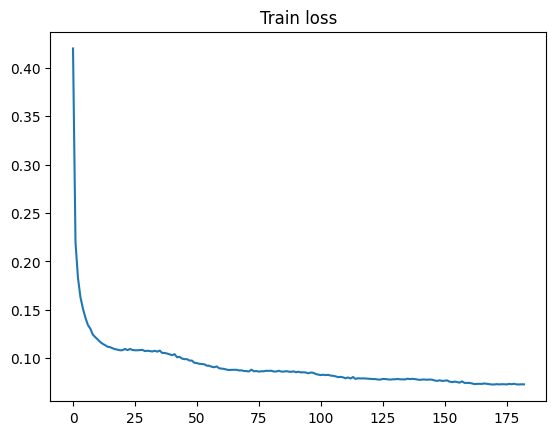

In [33]:
plt.title("Train loss")
plt.plot(save_train_loss)
plt.show()

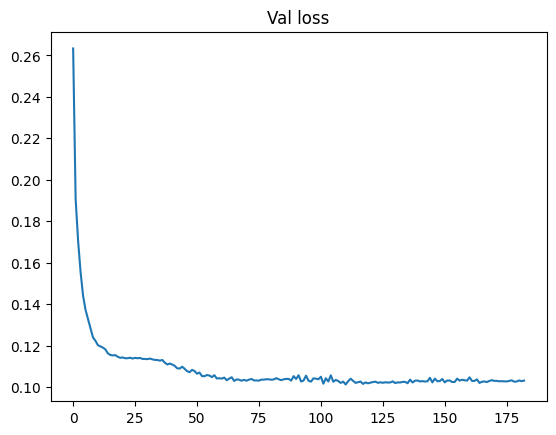

In [34]:
plt.title("Val loss")
plt.plot(save_val_loss)
plt.show()

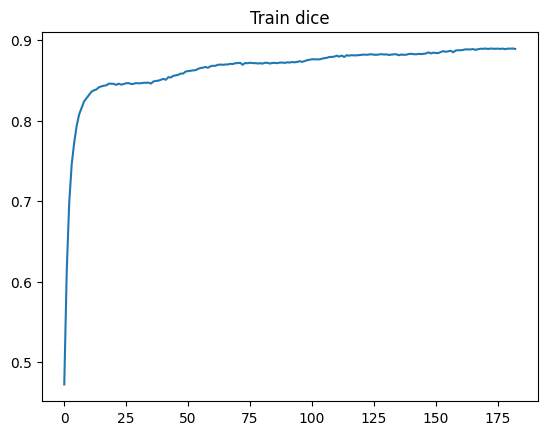

In [35]:
plt.title("Train dice")
plt.plot(save_train_dice)
plt.show()

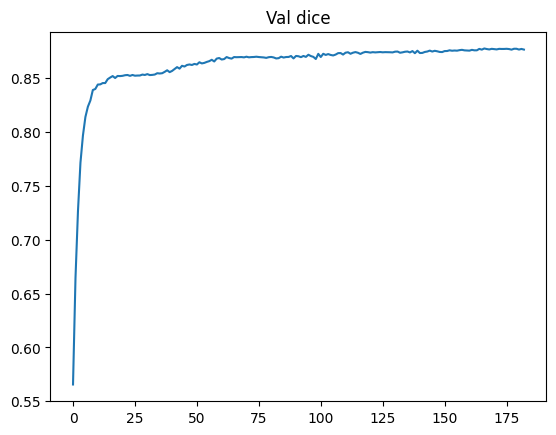

In [36]:
plt.title("Val dice")
plt.plot(save_val_dice)
plt.show()

# Surrogate class with auxiliary task

In [38]:
indiv_segmentation_from_cls_model.encoder

ResNetEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

In [39]:
indiv_classification_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [ ]:
def make_surrogate(image):
    

In [ ]:
def train_seg_aux(train_loader,model,criterion, optimizer, device):
    losses = []
    train_dice_dict = dict()
    model.to(device)
    model.train()
    for image, mask in train_loader:
        image,mask = image.to(device), mask.to(device)
        surrogate_label = make_surrogate(image)
        logits = model(image)
        preds = torch.argmax(logits, axis = 1)
#         print("logits:",logits.size())
#         print(logits)
#         print("mask:",mask.size())
#         print("preds",preds.size())
        loss = criterion(logits,mask)
        dice_dict = multiclass_dice_score(preds,mask)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        for key in dice_dict.keys():
            if key in train_dice_dict:
                train_dice_dict[key].append(dice_dict[key])
            else:
                train_dice_dict[key] = [dice_dict[key]]
    
    #average dice dict
    for key in train_dice_dict.keys():
        train_dice_dict[key] = np.mean(train_dice_dict[key])
    return np.mean(losses), train_dice_dict

In [ ]:
from tqdm.notebook import tqdm
save_train_loss = []
save_train_dice =[]
save_val_loss = []
save_val_dice = []
best_val_dice = 0.
best_val_acc = 0.
max_patience = 15
indiv_segmentation_from_cls_model.to(device)

for epoch in tqdm(range(args.EPOCHS)):
    train_loss, train_dice = train_seg_aux(segmentation_loaders['train_loader'], indiv_segmentation_from_cls_model, criterion, indiv_segmentation_from_cls_optimizer,device)
    val_loss, val_dice = eval_seg(segmentation_loaders['val_loader'], indiv_segmentation_from_cls_model, criterion, device)
    avg_train_dice, avg_val_dice = np.mean(list(train_dice.values())),np.mean(list(val_dice.values()))
    save_train_dice.append(avg_train_dice)
    save_val_dice.append(avg_val_dice)
    save_train_loss.append(train_loss)
    save_val_loss.append(val_loss)
    print(f"======= epoch {epoch} ========")
    print("avg train dice:",avg_train_dice,"avg val dice:",avg_val_dice)
    print("train dice:",train_dice)
    print("val dice:",val_dice)
    if avg_val_dice > best_val_dice:
        print("model updated at epoch:",epoch)
        best_model = copy.deepcopy(indiv_segmentation_from_cls_model)
        best_val_dice = avg_val_dice
        patience = 0
    else:
        patience +=1
    
    if patience > max_patience:
        break
    indiv_segmentation_from_cls_scheduler.step()
torch.save({"save_train_loss":save_train_loss,"save_train_dice":save_train_dice,"save_val_loss":save_val_loss,"save_val_dice":save_val_dice},"fron_cls_transfer_seg_log.pt")

# Weight Sharing

# SimPara